> Compute, plot and manipulate EEG power spectra using Morlet Wavelets


In this example we will load the fmailiar MNE sample data and compute Morlet Wavelets.

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample

import meeglet
from meeglet import compute_spectral_features, spectrum_from_features

In [ ]:
 #| hide

import warnings
mne.viz.set_browser_backend('matplotlib')
mne.utils.set_log_level('critical')
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

Using matplotlib as 2D backend.


## Load data 

Let's read in the raw data and pick the EEG channel type

In [ ]:
data_path = sample.data_path()

raw = mne.io.read_raw_fif(data_path / 'MEG/sample/sample_audvis_raw.fif')
raw = raw.pick_types(meg=False, eeg=True, eog=False, ecg=False, stim=False,
                     exclude=raw.info['bads']).load_data()
raw.set_eeg_reference(projection=True).apply_proj()

Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,59 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


## Compute the features using the high-level API of meeglet.

This will return tow simple namespaces, one for the spectral features, one for the meta data.

In [ ]:
features, info = compute_spectral_features(
    raw, foi_start=2, foi_end=32, bw_oct=0.5, density='Hz', features='pow')

## Use MNE high-level plotting API
To make use of MNE's latest Spectum data container, we can use a little helper function from `meeglet`

### Power spectrum plot (2D lines)

Now we can readily make use of MNE's plotting API. Let's first plot data on a linear scale

In [ ]:
spectrum = meeglet.spectrum_from_features(
    features.pow, info.foi, raw.info
)

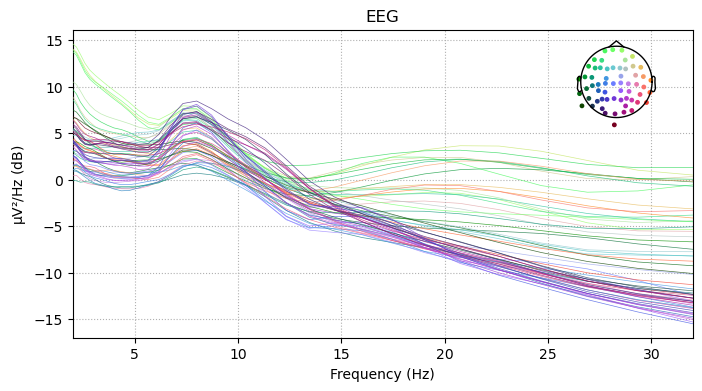

In [ ]:
fig = plt.figure()
spectrum.plot(dB=True, axes=plt.gca())
fig.set_size_inches(8, 4);
fig;

Let's update the output to log scale with base = 2. Note that for a base 10 logarithm, we could have simply used the `xscale` from the plot method.
Some adjustments follow to reflect updated scaling

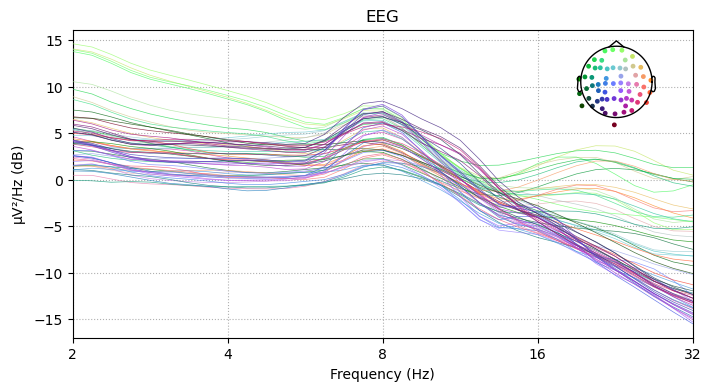

In [ ]:
fig = plt.figure()

spectrum.plot(dB=True, axes=plt.gca())

fig.axes[0].set_xscale('log', base=2)
fig.axes[0].set_xticks(2 ** np.arange(1, 6), 2 ** np.arange(1, 6))

fig.set_size_inches(8, 4);
fig;

### Topographic plots

Using default settings, MNE will returns bands.

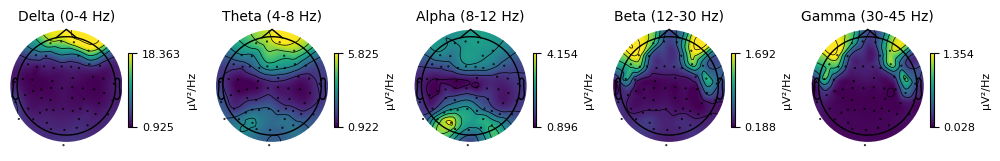

In [ ]:
spectrum.plot_topomap(cmap='viridis');

But we can simply pass frequency coordinates as tuples. Of note, due to the logarithmic frequency grid and the particular octave band width, one octave is reached every 8 indices if we use a band width of 0.5 and bw / 4 spaxcing (defaults).

In [ ]:
info.foi[::8]

array([ 2.,  4.,  8., 16., 32.])

In [ ]:
freqs = info.foi[::8][2:]

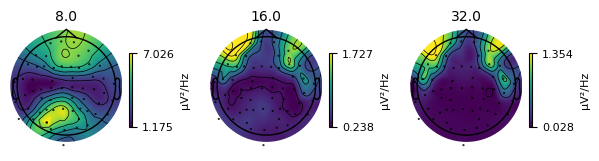

In [ ]:
spectrum.plot_topomap(zip(freqs, freqs), cmap='viridis');

Finally, we can normalize the output, such that the total power adds up to one.

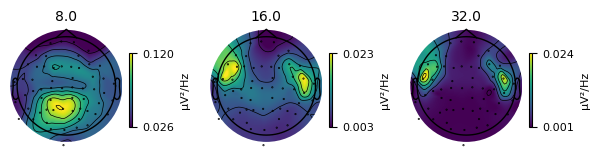

In [ ]:
spectrum.plot_topomap(zip(freqs, freqs), cmap='viridis', normalize=True);

## Advanced Options

### Octave scaling

To take into account a-periodic dynamics, we can integrate over octaves, i.e. $log_2(Hz)$. As a result, the 1/f will be mitigated.


In [ ]:
features2, info = compute_spectral_features(
    raw, foi_start=2, foi_end=32, bw_oct=0.5, density='oct', features='pow')

spectrum_oct = spectrum_from_features(
    data=features2.pow,
    freqs=info.foi,
    inst_info=raw.info
)

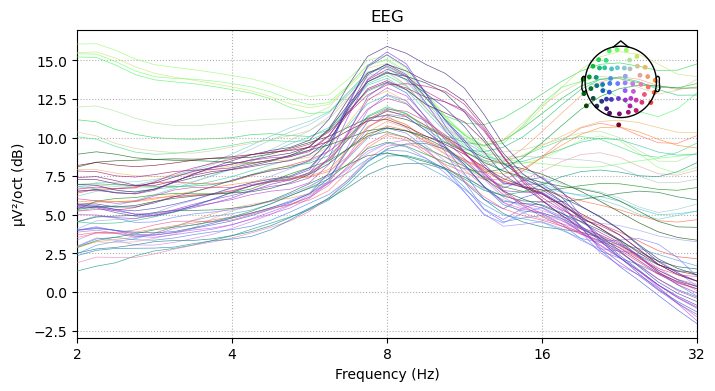

In [ ]:
fig = plt.figure();
spectrum_oct.plot(dB=True, axes=plt.gca());
fig.set_size_inches(8,4);
fig.axes[0].set_xscale('log', base=2);
fig.axes[0].set_xticks(2 ** np.arange(1, 6), 2 ** np.arange(1, 6));
for tt in fig.findobj(plt.Text):
    if '/Hz' in tt.get_text():
        tt.set_text(tt.get_text().replace('Hz', 'oct'));
fig;

### Frequency shifting

We can now explore shifting in log domain. We will apply a frequency shiftt to arbitrary reference=12Hz.
Then we plot both results using the original frequency grid

In [ ]:
reference = 12
peak = 8  # we know this subject has an 8 Hz peak.
shift = peak / reference 

features3, info3 = compute_spectral_features(
    raw, foi_start=2, foi_end=32, bw_oct=0.5, density='oct',
    features='pow', freq_shift_factor=shift
)

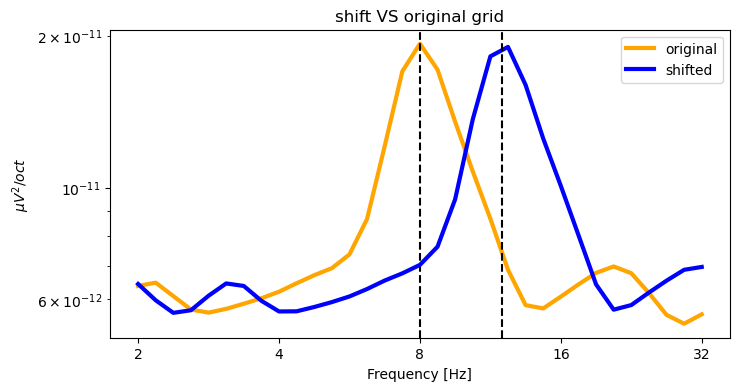

In [ ]:
plt.close('all')
fig = plt.figure()
plt.ion()
plt.title('shift VS original grid')
plt.loglog(info.foi, features2.pow.mean(0), label='original', color='orange',
           linewidth=3)
plt.axvline(peak, color='black', linestyle='--')
plt.semilogy(info3.foi, features3.pow.mean(0), label='shifted', color='blue',
             linewidth=3)
plt.axvline(reference, color='black', linestyle='--')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'${\mu}V^2/oct$')
fig.axes[0].set_xscale('log', base=2)
fig.axes[0].set_xticks(2 ** np.arange(1, 6), 2 ** np.arange(1, 6))
fig.set_size_inches(8, 4)
fig;

One can nicely see the up-shift while the x axes are identical.

We can now see that the default log-scaled smoothing leads to smoother PSD
estimates in high frequencies. On the left-hand side, we see that log scaling VS
linear scaling are more similar in low frequencies.